The dataset **radiology_costs.csv** (see `./data`) has information associated with patients who had a knee MRI. This dataset contains the following information:

- `age`: patient’s age,
- `female`: indicator if the patient is female,
- `population`: the population associated with the patient’s home zip, 
- `hospital`: binary feature that takes the value one if the patient was imaged at a hospital and zero if the patient was imaged at a community clinic
- `upstream_costs`: the yearly overall medical costs prior to the initial knee MRI
- `downstream_costs`: the yearly overall medical costs that follow the initial knee MRI
- `er`: indicates if the image took place at an Emergency Room (ER) visit


This demo provides (prototypical) solutions for the following questions:

- Option A (Inference):  What features drive higher downstream costs? What assumptions did you make to answer this question? What are the limitations of your analysis?

- Option B (Prediction):  Build a model to predict downstream costs. How do you assess your model’s predictive performance? What assumptions did you make when building your prediction model? What are the limitations of your analysis?


## Preliminary Step

In [ ]:
# Preliminary step
# You may need to install the following non-standard libaries
!pip install shap

# Run this demo on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys, os

# Parameters for data
input_dir = "/content/drive/MyDrive/Colab Notebooks/Your_Directory"

# Paramters for data transformation
tApplyScaling = True # apply feauture scaling (e.g. Minmax)? 
tApplyPowerTransformation = False # apply power transformation? 
tOutliers = False # identify and remove outliers? 
tModelSelection = True # attempt model selection? 

# print(os.listdir(input_dir))
sys.path.append(input_dir)
print(sys.path)

In [ ]:
import shap 

import numpy as np
import pandas as pd

import utils2
from utils2 import is_close

import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator # used to force yticks to assume integer values
plt.style.use('ggplot')

# Only show 5 numbers after the decimal
# pd.options.display.precision = 5

In [ ]:
from data_pipeline import fraction_rows_missing, load_data, toXY, toDF

# Load data: Prior to EDA, set dropna to False to gather the statistics of potential missing values
df = load_data(input_file="radiology_costs.csv", input_dir=input_dir, dropna=False, shuffle=False)

### Exploratory Data Analysis (EDA)

In [ ]:
df.sample(frac=1.0).head()

# df.sort_values(['population'], ascending=False).head(10)

,age,female,upstream_costs,er,hospital,population,downstream_cost
2219,56,0,298.84,0,0,710776,1978.61
5635,50,0,76.72,0,1,1975,2359.60
8681,46,0,181.12,0,0,159863,1560.48
3459,52,1,107.98,0,1,2609626,2927.24
6106,47,0,173.39,0,0,2009674,1567.61


EDA allows us to understand the data better and have a better gauge on what models to use for subsequent predictive analytics. A few key steps include: 

- Check missing values. 
   - In the radiology cost data, only 'downstream_cost' has missing values
   - Since 'downstream_cost' is what we wish to predict (including finding its associattion between other covariates), the rows where 'downstream_cost' is missing can be viewed as a holdout/test set. 
   - Later on in the modeling section, we will train a model predicting the cost using the other covariates
- Determine the data type. In particular, are these variables numerical  categorical, ordinal, text, etc.? 
   - 'age', 'upstream_costs', 'population' and 'downstream_cost' are numerical variables, although their properties can be quite different: 'age' in this context is more of a discrete number and so is the zip code, while the others are more of continous variables. 
   - 'female', 'hospital' and 'population' are categorical but more specifically binary variables. 

- Find the "shape" of the data: gather statistics of variables and observe the data distribution. 
  - Depending on the chosen statistical model, it may be desirable to transform the variables such that they follow more of a Gussian distribution due to the inductive bias of the model. 

- Identify potential outilers as one of main reasons of skewed data distribution and statistics; determining outliers can be subjective and it depends on the domain knowledge as well. In this data set (radiology_costs.csv), I decided to not remove any potential outliers as these values are still reasonable and possible.

- (Optinally) perform data transformation, i.e. transform the covarites such that their values falls within a consistently smaller range (e.g. between 0 and 1) or alternatively use standardization. In this demo, I choose to use Minmax normalization. 

- Data cleaning and error correction. This is not included in this demo. 
   - In relation to the outlier detection, some variables may carry problematic values. 
   - `population` for instance may reference the zip codes with two different standards; perhaps one is coming fron the new system while the others comes from an old system. However, in the interest of time, I did not attempt to fix this inconsistency. 



In [ ]:
N0 = N_total = df.shape[0]
r_missing = fraction_rows_missing(df)

print(f"> Sample size, N={N0}")
print(f"> Ratio of rows with nulls (i.e. missing values): {r_missing:.3g}, N={int(r_missing * N0)}") # 9.09e-06

vars_hasnull = [col for col in df.columns if df[col].isnull().any()]
print(f"> Variables with missing values: {vars_hasnull}")

target = 'downstream_cost'

# Since we are trying to predict downstream cost itself, we'll not attempt to impute it but instead ...
# ... use this data subset as the "holdout test data" for the trained regression model and ... 
# ... verify the model accuracy once their "labels" or the true costs are known
# ... drop all rows where downstream costs are missing
df_labeled = df0 = df.dropna(subset=[target, ], how='any')
N_labeled = df_labeled.shape[0]
assert is_close((N0-N_labeled)/N0, r_missing)

df_holdout = df_holdout_test = df[df[target].isnull()]  
# NOTE: 
#     Reserve 'df_test' for the test split in a cross validation (CV) for model evaluation
#     We use 'df_holdout' to refer to the hold out test data where labels are unknown and to be verified.
#     A test split (to be referenced by df_test or X_test) in a CV however corresponds to those
#     with known labels

N_holdout = df_holdout.shape[0] # Cal 'holdout '
assert N_holdout + N_labeled == N_total
print(f"> Size(train): {N_labeled}, Size(holdout_test): {N_holdout}")

# Basic statistics, by which we can already observe some trends 
# E.g. age and uptream_costs are positively corrleated with downstream_costs
df_labeled.describe().T

> Sample size, N=10000
> Ratio of rows with nulls (i.e. missing values): 0.283, N=2829
> Variables with missing values: ['downstream_cost']
> Size(train): 7171, Size(holdout_test): 2829


,count,mean,std,min,25%,50%,75%,max
age,7171.0,4.617194e+01,6.897749e+00,25.00,41.000,46.00,51.000,79.0
female,7171.0,5.082973e-01,4.999660e-01,0.00,0.000,1.00,1.000,1.0
upstream_costs,7171.0,1.682620e+02,8.963820e+01,25.48,105.195,148.95,209.680,938.8
er,7171.0,1.715242e-02,1.298482e-01,0.00,0.000,0.00,0.000,1.0
hospital,7171.0,3.975736e-01,4.894305e-01,0.00,0.000,0.00,1.000,1.0
population,7171.0,1.756822e+06,1.671375e+06,250.00,2103.000,1444517.00,3257456.000,4999094.0
downstream_cost,7171.0,2.140700e+03,5.502637e+02,821.23,1742.380,2102.11,2482.945,5746.0


### More EDA and Creating Training Data

- Define the features set and the target variable
- Scale the features (e.g. Minmax scaling) an appropriate range (we will use minmax in this demo, since not all variables follow Gaussian distribution); feature scaling helps in training ML models that depend on gradient computations (logistic regression, NNs), distance measures (e.g. kNN, SVM), etc. 
- Observe the data distribution; use appropriate power transformation to make the data more Gaussian-like (optional depending on the model)
  - Many algorithms like linear regression explicitly assume the variables have a Gaussian distribution. Other nonlinear algorithms may not make this assumption, yet often perform better when variables follow a Gaussian distribution.
  - Skewed data distribution is less of a concern for tree-based models such as Random Forest Regression (which we will use in this demo)

  - feature selection: This is not directly addressed by this demo; however, it is related to the analysis later on using SHEP for quantifying feature importance. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f401ba12ed0>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

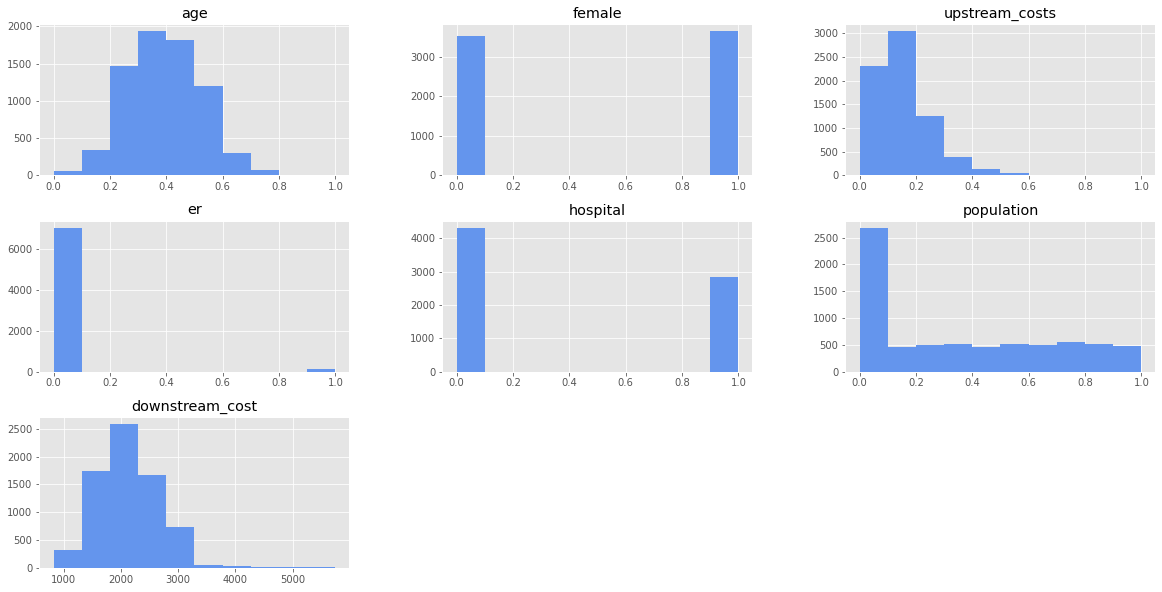

In [ ]:
from sklearn import preprocessing

df = df_labeled # let's just assume that the data minus the holdout set is our final (training) data set

# (X, y)
cols_y = ['downstream_cost', ]
cols_x = feature_set = list(df.drop(cols_y, axis=1).columns)

if tApplyScaling: 
    # Normalize feature values via minmax scaler
    # Note: 
    # 1. Feature scaling improves the convergence of gradient-based optimization such as steepest descent algorithms
    # 2. Minmax scaling won't change the data distribution (the skewed remains skewed)
    minmax_scaler = preprocessing.MinMaxScaler()
    df[feature_set] = minmax_scaler.fit_transform(df[feature_set])
    # ... Normalizing the target will not affect shape of the hypothesis function i.e. the model (f(x)), therefore, ...
    # ... it's generally unnecessary to scale y (i.e. downstream_cost in our case)

plt.clf()

# Observe data distribution; skewed data distribution may be indicative of the need of data transformation
# fig = plt.figure(figsize = (15,20))
# ax = fig.gca()
df.hist(color='cornflowerblue', figsize=(20, 10)) 

#### Identifying outliers 
- We probably do not want to remove outliers ourselves because after EDA, these "unusual" values still seem reliable
- Use power transformation to alleviate the skewness

In [ ]:
from data_pipeline import find_outliers, reject_outliers

# Candidate variables with skewed distributions to be poewr-transformed (except for binary variables)
vars_to_transform = ['age', 'upstream_costs', 'population']

df2 = load_data(input_file="radiology_costs.csv", input_dir=input_dir, dropna=False, shuffle=False)
df2 = df2.dropna(subset=[target, ], how='any')

# Are they all strickly positive? If so, can consider Box-Cox; otherwise use Yeo-Johnson
# print(np.sum((df[vars_to_transform]==0).sum(axis=0)))
for v in vars_to_transform: 
    subset = df2[df2[v]<=0]
    if len(subset) > 0: 
        print(f"> Variable: {v} has non-positive values:\n{df2[df2[v]<=0]}\n")
    
# Let's assume outliers are those located 3 std away
for v in vars_to_transform: 
    values = df2[v].values
    idx_outliers = find_outliers(values, m=3)
    n = len(idx_outliers)
    m, med = np.mean(values), np.median(values)
    print(f"> '{v}' has n={n} potential outlies (mean={m}, median={med})")
    if n > 0: 
        print(f"> ... example outliers: {min(values[idx_outliers])}, {max(values[idx_outliers])}")
    

> 'age' has n=28 potential outlies (mean=46.17194254636731, median=46.0)
> ... example outliers: 25, 79
> 'upstream_costs' has n=115 potential outlies (mean=168.26199135406495, median=148.95)
> ... example outliers: 437.81, 938.8
> 'population' has n=0 potential outlies (mean=1756821.9304141682, median=1444517.0)


In [ ]:
# Power transformation using Yeo–Johnson transformation
from sklearn.preprocessing import PowerTransformer
from data_pipeline import toXY, toDF

# X, y, feature_set, target = toXY(df, cols_y=['downstream_cost'], untracked=[])

# Candidate variables with skewed distributions to be poewr-transformed (except for binary variables)
vars_to_transform = ['age', 'upstream_costs', ] # 'population'
method = 'box-cox'
if tApplyPowerTransformation: 
    print(f"[info] Applying {method} transformation")
    
    # Also standardize the variable to improve convegence in gradient decent
    boxcox = PowerTransformer(method=method, standardize=True)
    
    X_trans = boxcox.fit_transform(df[vars_to_transform].values)
    df[vars_to_transform] = X_trans
    
    plt.clf() 
    df.hist(color='cornflowerblue', figsize=(20, 10)) 

### Model Training and Model selection
- Perform a hyperparameter grid search to find the best-performing random forest model. 
- The choice for candidate hyperparamters is defined in the next cell.

In [ ]:
# Define ranges for the chosen random forest hyperparameters 
hyperparams = {
    
    # how many trees should be in the forest (int)
    'n_estimators': [50, 100, 500, 700],

    # the maximum depth of trees in the forest (int)
    
    'max_depth': [4, 8, None, ], # [4, 5, 8, 10, 25, ],
    
    # the minimum number of samples in a leaf as a fraction
    # of the total number of samples in the training set
    # Can be int (in which case that is the minimum number)
    # or float (in which case the minimum is that fraction of the
    # number of training set samples)
    'min_samples_leaf': [2, 4, 8, ] # [4, 8, 0.01, 0.05, 0.1, 0.2, 0.25, ],
}

### Model Selection

- **Random Forest Regression** is employed as the baseline model for this demo
- In the model selection stage, we attempt to find the best hyperparamter setting for the given model (as defined by the previous cell) 
   - Split the labeled data into training and validation sets, assuming that a test split ratio of 20% (i.e. an 80%-20% split)
   - Use the training split (n=5736) to fit the model and the validation split (n=1435) to evaluate the model
   - We then loop through all the possible combinations of the hyperparameters to find the best setting as evaluated by the validation split

- Once the best hyperparamters are determined, we then __re-train the RF regression model using the entire label data.__
- Finally, we obtained the final model with the desired hyperparamters; this model can then be used to predict the unlabeled data (n=2829)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from data_pipeline import make_training_data
from model import demo_model_selection, demo_rf_regression, evaluate, random_forest_grid_search

model = RandomForestRegressor()
best_hyperparams = {}

X, y, feature_set, target, X_holdout = make_training_data(input_file="radiology_costs.csv", input_dir=input_dir, verbose=0, include_holdout=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
N_train, N_val = X_train.shape[0], X_val.shape[0]
N_test = X_holdout.shape[0] # this dataset does not yet have labels (cost unknown)

print(f"\nSample Size > N_train: {N_train}, N_val: {N_val}")
print(f"... N_holdout: {N_test}\n")

if tModelSelection: 
    model, best_hyperparams = random_forest_grid_search(X_train, y_train, X_val, y_val, hyperparams=hyperparams)
    print("")
    # Alternatively, all these steps including model selection via grid search is ...
    # ... encapsulated within demo_model_selection()
    # model, hyperparameters = demo_model_selection()


[debug] type(y): <class 'numpy.ndarray'>, shape(y): (7171,)

Sample Size > N_train: 5736, N_val: 1435
... N_holdout: 2829

(holdout_grid_search) Searching for the best hyperparameters ...
... [1/36] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 2}
... Val RMSE: 150.31950295713844

... [2/36] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 4}
... Val RMSE: 150.69298324946544

... [3/36] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 8}
... Val RMSE: 148.2690848999574

... [4/36] {'n_estimators': 50, 'max_depth': 8, 'min_samples_leaf': 2}
... Val RMSE: 43.27424943701446

... [5/36] {'n_estimators': 50, 'max_depth': 8, 'min_samples_leaf': 4}
... Val RMSE: 50.764482070640106

... [6/36] {'n_estimators': 50, 'max_depth': 8, 'min_samples_leaf': 8}
... Val RMSE: 55.98018154407738

... [7/36] {'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 2}
... Val RMSE: 35.189199711813686

... [8/36] {'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 4}
...

In [ ]:
# Re-train the model using the entire labeled data (and use the model to predict the holdout dataset)
model = RandomForestRegressor()
if tModelSelection: 
    assert len(best_hyperparams) > 0
    model.set_params(**best_hyperparams)
model.fit(X, y)

# print("\n> Evaluate the default RF regressor.")
# evaluate(model, X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

#### Verifying the model 

In [ ]:
df_train = toDF(X_train, cols_x, y_train, cols_y)
# print(df_train.head())

target = 'downstream_cost'
prediction = 'predicted_cost'
X_train_cost = df_train.copy(deep=True)
# X_train_cost[prediction] = model.predict(X_train).reshape((-1, 1))
X_train_cost.loc[:, prediction] = model.predict(X_train)
X_train_cost = X_train_cost.sort_values(by=target, ascending=False)

# inverse feature scaling 
X_train_cost[cols_x] = minmax_scaler.inverse_transform(X_train_cost[cols_x])
X_train_cost.head(20)

,age,female,upstream_costs,er,hospital,population,downstream_cost,predicted_cost
2711,62.0,1.0,100.06,1.0,1.0,3735424.0,5746.00,5501.222460
1858,59.0,1.0,135.71,1.0,1.0,3055382.0,5611.73,5508.424732
1086,54.0,1.0,264.20,1.0,1.0,2424977.0,5486.23,5388.932015
4400,55.0,1.0,104.83,1.0,1.0,4568522.0,5325.74,5392.567721
1336,53.0,1.0,176.61,1.0,1.0,2770293.0,5305.03,5281.483029
913,57.0,0.0,449.60,1.0,1.0,3522398.0,5215.75,4848.995292
144,48.0,1.0,166.94,1.0,1.0,1939194.0,5007.70,4973.595282
1886,48.0,1.0,123.79,1.0,1.0,764.0,4996.90,5014.303051
5557,48.0,1.0,116.27,1.0,1.0,1981.0,4976.86,5004.525137
4131,47.0,1.0,152.01,1.0,1.0,2440874.0,4911.51,4890.747619


In [ ]:
df_test = toDF(X_holdout, cols_x)
# print(df_test.head())

target = 'downstream_cost'
# prediction = 'predicted_cost'
X_test_cost = df_test.copy(deep=True)
X_test_cost[target] = model.predict(X_holdout).reshape((-1, 1))
X_test_cost = X_test_cost.sort_values(by=target, ascending=False)

# inverse feature scaling 
X_test_cost[cols_x] = minmax_scaler.inverse_transform(X_test_cost[cols_x])
X_test_cost.head(20)

,age,female,upstream_costs,er,hospital,population,downstream_cost
1894,64.0,1.0,379.22,1.0,1.0,3786968.0,5517.424575
1244,67.0,1.0,171.94,1.0,1.0,4741887.0,5510.432058
456,59.0,1.0,145.45,1.0,1.0,4444521.0,5509.614526
114,69.0,1.0,139.55,1.0,1.0,3465654.0,5507.920605
598,64.0,1.0,167.76,1.0,1.0,4585434.0,5506.479034
973,59.0,1.0,91.86,1.0,1.0,3245517.0,5503.411435
1782,60.0,1.0,82.81,1.0,1.0,4527891.0,5499.641331
1637,61.0,1.0,114.78,1.0,1.0,4446148.0,5499.298906
61,58.0,1.0,164.34,1.0,1.0,3829668.0,5479.553346
682,63.0,1.0,361.06,1.0,1.0,1860.0,5473.693697


### Model Interpretation

Using a random forest regression allows us to potentially identify complex non-linear relationship between the covariates and the target (downstream cost), but it does not have a natural interpretability of feature importance as does the linear regression model (where and the p-values and the coefficient can signify the presence and the degree of association with the target). 

In this demo, we will use **SHAP** (SHapley Additive exPlanations) to explain the prediction by quantifying the **additive importance** of each feature to the prediction.

- We'll use the [shap library](https://github.com/slundberg/shap) to identify features that drive the downstream cost for our random forest model. 



#### Glopal Interpretability
- Run the next cell to see a summary plot of the SHAP values for each feature on the training data. 

In [ ]:
# import shap
df_train = toDF(X, cols_x, y, cols_y)

# Computing Shapley values can be time-consuming; subsample to speed up 
df_train = df_train.sample(n=1500)

X_train = df_train.copy(deep=True)
X_train = X_train.drop([target], axis=1)

plt.clf()
f = plt.figure()
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

input_path = os.path.join(input_dir, 'feature-importance-bar.tif')
f.savefig(input_path, bbox_inches='tight', dpi=300)


#### Observations 

- From the summary plot above, we see that top 3 variables with relatively high global feature importance are: 'hospital', 'female' and 'age'

- 'population' does not exhibit a strong correlation with the downsteram cost (more to follow next)

In [ ]:
plt.clf()
f = plt.figure(figsize = (18,24))
shap.summary_plot(shap_values, X_train)
input_path = os.path.join(input_dir, 'summary_plot-global.tif')
f.savefig(input_path, bbox_inches='tight', dpi=300)

In [ ]:
shap.dependence_plot("age", shap_values, X_train)
shap.dependence_plot("upstream_costs", shap_values, X_train)
shap.dependence_plot("population", shap_values, X_train)

# Dependence plot perhaps does not offer the best visualization for binary variables 
# print('\n')
# shap.dependence_plot("hospital", shap_values, X_train)
# shap.dependence_plot("female", shap_values, X_train)
# shap.dependence_plot("er", shap_values, X_train)

#### Observations 
- ‘age’ for example is generally positively correlated with the cost
- image taken at the hospital and/or ER, female patients generally also drives up the cost
- ‘population’, on the other hand, exhibits no apparent correlation (neither positively nor negatively) with the cost. This could also be due to the fact that the zip code was not cleaned. 
   - According to the EDA section, there might be a mixture of standards present for the zip code, which would then distort the signal in its association with the cost. 


### Local Interpretability: Individual SHAP value

In [ ]:
df_test = toDF(X_holdout, cols_x)
# print(df_test.head())

target = 'downstream_cost'
# Get the predictions and put them with the test data.
X_output = df_test.copy(deep=True)
N_test = X_output.shape[0]

X_output[target] = np.round(model.predict(X_holdout).reshape((-1, 1)), 2)

# Verify predicted cost (close to the true downstream cost?)
print(X_output.head())

# Randomly pick some observations
random_picks = np.random.choice(range(N_test), 50)
X_subset = X_output.iloc[random_picks]
X_subset.head()

In [ ]:
# Write in a function
def shap_plot(j):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_subset)
    p = shap.force_plot(explainer.expected_value, shap_values[j], X_subset.iloc[[j]])
    return p

In [ ]:
# Initialize your Jupyter notebook with initjs(), otherwise you may get an error message.
shap.initjs()

i = 1 # pick an individual patient and observe how each covariate contributes to predicting the cost
shap_plot(i)

In [ ]:
shap.initjs()

i = 3
shap_plot(i)

### Observations
In patient #1 (i=1), for instance, we see that being a female with the image taken in the ER pushes the cost higher, while her age (relatively younger) drives down the cost. 

Note that the results will be slightly different in each run. The individual feature importance will likely not coincide with the overall/global feature importance (being derived in the average sense). For instance, across all patients, if the image was taken in a hospital setting, it usually drives up the cost; however, this may not be the case for individual patient (e.g. patient #3)
